### Бинарная классификация тикетов сервиса краудсорсингового распознавания музыки.

На основе имеющихся данных (15 тыс. тикетов, пользователи, действия, переписка в чатах тикета) создадим модель, которая бы оценивала вероятность успешного закрытия тикета.

Данные собраны в сервисе Hazanda.com - интернет-площадка формата хелпдеск, где
любой желающий может оставить заявку(тикет) на распознавание, зачастую долго
разыскиваемого, музыкального трека в любом виде (текст, ссылка, файл или сделать
аудиозапись на сайте). Музыка, как сегмент, выбрана из-за очевидной проблематики
распознавания треков различными сервисами. В сервисе работают эксперты -
меломаны с феноменальной памятью, способные определять названия треков,
которые, например не смог определить Shazam. Идеальная модель сервиса может
выглядеть, как универсальный сервис для разнородных типов тикетов, которые
обрабатываются не только экспертами, но технологиями цифровых отпечатков
внутренней базы, так и через API ко внешним источникам, например, Arcloud. Сервис
находится на пилотной стадии и развивается в свободное время.

In [87]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split,KFold
from catboost import CatBoostClassifier, Pool
import lightgbm as lgb

from catboost import CatBoostRegressor
from nltk import sent_tokenize, word_tokenize, regexp_tokenize
from pymorphy2 import MorphAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

import gc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_column', 10000)
pd.options.mode.use_inf_as_na = True
display(HTML("<style>.container { width:80% !important; }</style>"))
from sklearn.metrics import roc_auc_score

### Pre-processing

In [88]:
users = pd.read_csv('users.csv')
users.rename(columns={'id':'user_id'},inplace=True)
users.sample(5)

,user_id,email,login,mailing_enable,name,status,type,oauth_source
4746,4747,andriy.havrylov**@rambler.ru,user-4747,True,andriy,ACTIVE,USER,NaN
5902,5903,mikhno.panteley**@yandex.ru,user-5903,True,NaN,ACTIVE,USER,NaN
9819,9820,89604308787,user-9820,True,NaN,ACTIVE,USER,NaN
5651,5652,vladshetinin**@mail.ru,user-5652,True,Влад,ACTIVE,USER,NaN
10880,10881,lena_2403-**@mail.ru,user-10881,True,Алёна,ACTIVE,USER,VK


In [89]:
tickets = pd.read_csv('tickets.csv')
tickets = tickets.merge(users[['user_id','mailing_enable','type','oauth_source']],on='user_id',how='left')
tickets.sample(5)

,id,has_attachment,status,text,link,user_id,resolved_by_id,target_id,visits_count_admin,visits_count_expert,visits_count_user,mailing_enable,type,oauth_source
13644,13659,False,OPEN,дайте трек плз,http://hazanda.com/ticket-13659,10813,NaN,NaN,NaN,NaN,1.0,True,USER,NaN
1435,1438,False,RESOLVED,что за музыка на 4:55 мин,http://hazanda.com/ticket-1438,1743,833.0,715.0,NaN,4.0,24.0,True,USER,NaN
11458,11473,False,OPEN,https://m.youtube.com/watch?v=EXCR70eE42g&fea...,http://hazanda.com/ticket-11473,8218,NaN,NaN,NaN,NaN,3.0,True,USER,NaN
3403,3408,False,CLOSED,Омогите найти песню на арми хом #433 начинаетс...,http://hazanda.com/ticket-3408,2887,NaN,NaN,NaN,2.0,NaN,True,USER,NaN
1890,1893,False,RESOLVED,Подскажите пожалуйста трек),http://hazanda.com/ticket-1893,2168,723.0,970.0,NaN,8.0,5.0,True,USER,NaN


In [90]:
%%time
# Добавим в каждый тикет для каждого юзера отношение его закрытых тикетов в прошлом ко всем его тикетам в прошлом.
tickets['lucky_rate'] = 0 #чем выше показатель, тем чаще на тикеты данного пользователи давались ответы.
for u in tickets['user_id'].unique():
    t = list(tickets.loc[tickets['user_id']==u,'id'].unique())
    if len(t) == 1:
        tickets.loc[tickets['user_id']==u,'lucky_rate'] = -1   
    else:
        tickets.loc[(tickets['id']==t[0]),'lucky_rate'] = -1
        
        for i in range(1,len(t)):
            lucky_rate = tickets.loc[(tickets['status'].isin(['CLOSED','RESOLVED']))&(tickets['id'].isin(t[:i]))].shape[0]/tickets.loc[(tickets['id'].isin(t[:i]))]['id'].shape[0]
            tickets.loc[tickets['id']==t[i],'lucky_rate'] = lucky_rate
    #print(tickets.loc[tickets['user_id']==u,'lucky_rate'].round(2).values)

Wall time: 1min 41s


In [91]:
# Иногда эксперты не закрывают тикет, но ответ был дан, 
# поэтому в единицу таргета пойдут 2 категории, а в ноль все остальные.
tickets['target'] = 0
tickets.loc[tickets['status']=='CLOSED','target'] = 1
tickets.loc[tickets['status']=='RESOLVED','target'] = 1

In [92]:
tickets.loc[tickets["text"].notna(),"text"] = tickets.loc[tickets["text"].notna(),"text"].astype(str).apply(lambda x: x.lower())

for col in ['visits_count_admin','visits_count_expert','visits_count_user']:
    tickets[col] = tickets[col].fillna(0)

for col in ['has_attachment','mailing_enable']:
    tickets[col] = tickets[col].astype(int)
    
def tokenize_n_normalize(sent, pat=r"(?u)\b\w\w+\b", morph=MorphAnalyzer()):
    return [morph.parse(tok)[0].normal_form 
            for tok in regexp_tokenize(sent, pat)]
tickets["text"] = tickets["text"].astype(str).map(lambda x: " ".join(tokenize_n_normalize(x)))

cv = CountVectorizer(ngram_range = (1,5),min_df=10) #пока оставим стоп-слова
cv.fit(tickets["text"])
cv_data = pd.DataFrame(cv.transform(tickets["text"]).toarray(), columns = cv.get_feature_names())

In [93]:
notices = pd.read_csv('notices.csv')
notices = notices[notices.type != 'SOLVED']

In [94]:
tickets.rename(columns={'id':'ticket_id'},inplace=True)

In [95]:
oh_types = pd.get_dummies(notices[['ticket_id','type']],columns = ['type']).groupby('ticket_id').sum()
oh_types_div = oh_types.div(oh_types.sum(axis=1), axis=0)
oh_types_div.columns = ["share_{}".format(x) for x in oh_types.columns]

In [96]:
tickets = tickets.merge(oh_types,on='ticket_id',how='left')
tickets = tickets.merge(oh_types_div,on='ticket_id',how='left')

In [97]:
chat_messages = pd.read_csv('chat_messages.csv')
chat_messages.rename(columns={'id':'ticket_id'},inplace=True)
chat_messages.sample(5)

,ticket_id,text,author_id,chat_id
587,588,СПАСИБОЧКИ:3,336,267
17719,17720,TICKET_RESOLVED,712,9697
14446,14447,Здесь ремикс или кавер,833,7555
10199,10200,автор ролика использует музыку из бесплатной б...,712,4694
4179,4180,TICKET_RESOLVED,60,2157


In [98]:
statuses = pd.get_dummies(chat_messages[chat_messages['text'].isin(['TICKET_REOPEN','TICKET_IN_PROGRESS',
                                                                    'TICKET_OPEN'])][['ticket_id','text']],columns=['text']).groupby('ticket_id').sum()
statuses_div = statuses.div(statuses.sum(axis=1), axis=0)
statuses_div.columns = ["share_{}".format(x) for x in statuses.columns]

tickets = tickets.merge(statuses,on='ticket_id',how='left')
tickets = tickets.merge(statuses_div,on='ticket_id',how='left')
tickets

,ticket_id,has_attachment,status,text,link,user_id,resolved_by_id,target_id,visits_count_admin,visits_count_expert,visits_count_user,mailing_enable,type,oauth_source,lucky_rate,target,type_HARD,type_OBSCURE,type_OCCUPIED,type_WAITING,share_type_HARD,share_type_OBSCURE,share_type_OCCUPIED,share_type_WAITING,text_TICKET_IN_PROGRESS,text_TICKET_OPEN,text_TICKET_REOPEN,share_text_TICKET_IN_PROGRESS,share_text_TICKET_OPEN,share_text_TICKET_REOPEN
0,1,0,CLOSED,искать трек про лабутена помочь пожалуйста,http://hazanda.com/ticket-1,1,NaN,3.0,9.0,3.0,1.0,1,ADMIN,FB,-1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,CLOSED,трек 25 кто мочь опознать,http://hazanda.com/ticket-2,2,NaN,1.0,2.0,2.0,0.0,1,ADMIN,VK,-1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,0,CLOSED,ракамакафо чё за трек,http://hazanda.com/ticket-3,3,NaN,2.0,2.0,2.0,0.0,1,USER,NaN,-1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0,CLOSED,искать трек про свинюшка хорьковый,http://hazanda.com/ticket-4,2,NaN,4.0,2.0,1.0,0.0,1,ADMIN,VK,1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,CLOSED,нужный версия женский вокал начало как прикреп...,http://hazanda.com/ticket-5,4,NaN,6.0,4.0,1.0,0.0,1,USER,NaN,-1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15769,15784,0,OPEN,https youtu be 5ztrpyuy1sa,http://hazanda.com/ticket-15784,12886,NaN,NaN,0.0,0.0,3.0,1,USER,NaN,-1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15770,15785,0,OPEN,что за трек на задний фон,http://hazanda.com/ticket-15785,12887,NaN,NaN,0.0,0.0,1.0,1,USER,NaN,-1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15771,15786,0,OPEN,на 50 минута трек,http://hazanda.com/ticket-15786,12889,NaN,NaN,0.0,0.0,0.0,1,USER,NaN,-1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15772,15787,0,OPEN,что за музыка на 30 секунда до конец видео,http://hazanda.com/ticket-15787,12890,NaN,NaN,0.0,0.0,1.0,1,USER,NaN,-1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [99]:
tickets['count_tickets_by_user'] = tickets['user_id'].map(tickets['user_id'].value_counts())

tickets.drop(['status','link','user_id','ticket_id','text','target_id','resolved_by_id'],axis=1,inplace=True)
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for col in ['type','oauth_source']:
    print(col)
    tickets[col] = le.fit_transform(tickets[col].astype(str))
tickets.sample(5)

type
oauth_source


,has_attachment,visits_count_admin,visits_count_expert,visits_count_user,mailing_enable,type,oauth_source,lucky_rate,target,type_HARD,type_OBSCURE,type_OCCUPIED,type_WAITING,share_type_HARD,share_type_OBSCURE,share_type_OCCUPIED,share_type_WAITING,text_TICKET_IN_PROGRESS,text_TICKET_OPEN,text_TICKET_REOPEN,share_text_TICKET_IN_PROGRESS,share_text_TICKET_OPEN,share_text_TICKET_REOPEN,count_tickets_by_user
4772,1,0.0,2.0,1.0,1,2,2,-1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
7281,0,0.0,2.0,1.0,1,2,2,-1.0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,2
2069,0,0.0,4.0,6.0,1,2,2,-1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2816,0,0.0,4.0,3.0,1,2,2,-1.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
11902,0,0.0,0.0,1.0,1,2,2,-1.0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [100]:
cats = ['has_attachment','mailing_enable','type','oauth_source']
ids = [index for index, value in enumerate(X_train.columns) if value in cats]

In [101]:
X_train = tickets.drop(['target'],axis=1)
y_train = tickets['target']

In [102]:
X_train = pd.concat([X_train,cv_data],axis=1)
X_train.shape

(15774, 2166)

In [79]:
#оставим топ100 наиболее важных признаков
cols = ['lucky_rate','count_tickets_by_user', 'visits_count_user',
       'visits_count_expert', 'visits_count_admin',
       'трек', 'oauth_source', 'has_attachment', 'mailing_enable',
       'type_HARD', 'type_OBSCURE', 'share_type_OBSCURE', 'на', 'видео', 
       'share_type_HARD', 'share_type_WAITING', 'найти', 'песня', 'https', 'text_TICKET_REOPEN',
       'не', 'весь', 'играть', 'type_WAITING', 'помочь',
       'пожалуйста', 'text_TICKET_IN_PROGRESS', 'минута', 'музыка',
       'подсказать', 'type', 'com', 'вы', 'помочь найти', 'по',
       'благодарный', '05', 'https youtu', 'секунда', 'найти пожалуйста',
       'искать', 'название песнь', 'из', 'https vk', 'что', '2fpl_post_',
       'какой музыка', 'год', 'video', 'что за трек', '20', 'сезон',
       'видео https', 'очень', 'этот трек', 'начало', 'пожалуйста найти',
       'из видео', 'хотеть', 'vk', 'бы', 'который играть',
       'сказать пожалуйста', 'фон', 'нужно', 'конец', 'какой', 'если',
       '30', 'спасибо', 'распознать', 'text_TICKET_OPEN', 'играть это',
       '50', 'надо', 'название', 'как', 'трек на', 'после', 'просить',
       'начинать', '00', 'be', 'что за песня', 'музыка играть на', 'он',
       'оригинал', 'заранее спасибо', 'начинаться', 'ты', 'вот', 'идти',
       'задний', 'этот', 'помочь пожалуйста', 'подсказать что', 'самый',
       'это', 'найти песня', '11', 'там', 'играть на',
       'видео https www youtube', 'реклама', 'на минута', '40',
       'найти трек', 'это видео', 'плз', '03', 'https www youtube', 'кто',
       'подсказать песня', 'песня на', 'за', 'https coub',
       'не мочь найти', 'быть', 'com feed', 'за трек', 'трек из', 'фильм',
       'узнать', 'минута подсказать', 'заранее', 'слово', 'nan',
       'за музыка', 'найти музыка', 'но', 'начать', 'до', 'трек видео',
       'section', 'песня играть', 'com watch', 'найти трек из',
       'музыка из', 'она', 'трек из видео', 'com video', 'что за',
       'время', 'один', '12', 'coub', 'мочь', 'ссылка', 'мочь найти',
       '26', 'привет', 'знать', 'сказать', 'добрый', 'wall', '35',
       'type_OCCUPIED', 'можно', 'подсказать пожалуйста', 'когда', '31',
       'что за песня на', 'на видео', 'называться', 'youtube', '25',
       'youtube com', 'конец видео', 'за песня', 'то', 'http', 'list',
       'share_type_OCCUPIED', 'определить', 'какой трек',
       'трек начинаться', 'https www', 'песня из', 'за песня на',
       'найти песня из', 'ещё', 'подсказать название', 'который',
       'что за музыка', 'тот', 'петь', 'трек играть', 'подсказать трек',
       'нужный', 'ребята', 'youtu', 'помочь найти трек', 'здравствовать',
       'название трек',
       'подсказать пожалуйста что за', 'на 00', 'плиз',
       'как называться песня', 'какой песня играть', '28', '55', 'так',
       'трек пожалуйста', 'хотеть узнать', 'песнь из', '13', 'серия',
       'пожалуйста помочь', 'начинаться на', '19', 'какой музыка играть',
       'что за трек играть', '15', 'песнь', 'видео https www',
       'музыка на', 'момент', 'помочь найти песня', 'есть', 'не мочь',
       'https www youtube com watch', 'из это', 'видио',
       'трек из это видео', 'видео на', 'исполнитель', 'песня из видео',
       'танцевать', 'ролик', '16', 'на задний', 'пожалуйста название',
       'www youtube', 'как называться трек', 'трек который',
       'музыка играть', '23', 'www youtube com watch', 'название музыка',
       'share_text_TICKET_REOPEN', 'трэк',
       'самый начало', 'сериал', 'за песня играть', 'на 10']

In [81]:
X_train = X_train[cols]

In [82]:
X_train.to_pickle('X_train')
y_train.to_pickle('y_train')

In [83]:
X_train = pd.get_dummies(X_train,columns = cats)

In [84]:
from sklearn.model_selection import train_test_split, KFold
import xgboost as xgb
n_fold = 5
folds = KFold(n_fold, shuffle = True, random_state = 42)

params = {'tree_method': 'hist',
 'colsample_bytree': 0.95,
 'subsample': 0.6,
 'learning_rate': 0.02,
 'max_leaves': 128,
 'objective': 'binary:logistic',
 'max_depth': 10,
 'reg_alpha': 0.5,
 'min_child_weight': 5,
 'eval_metric': 'auc'}

oof_preds = np.zeros(tickets.shape[0])
feature_importance_df = pd.DataFrame()

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(tickets, y_train)):

    trn_x, trn_y = X_train.iloc[trn_idx], y_train.iloc[trn_idx]
    val_x, val_y = X_train.iloc[val_idx], y_train.iloc[val_idx]
    dtrain = xgb.DMatrix(trn_x, trn_y, feature_names=trn_x.columns,)
    dval = xgb.DMatrix(val_x, val_y, feature_names=val_x.columns,)

    
    clf = xgb.train(params=params, dtrain=dtrain, num_boost_round=50000, evals=[(dtrain, "Train"), (dval, "Val")],
        verbose_eval= 500, early_stopping_rounds=300)
    
    oof_preds[val_idx] = clf.predict(xgb.DMatrix(val_x))
    print('\nFold %2d AUC %.6f & std %.6f' %(n_fold + 1, roc_auc_score(val_y, oof_preds[val_idx]), np.std([oof_preds[val_idx]])))
    gc.collect()
    
print('\nCV AUC score %.6f & std %.6f' % (roc_auc_score(y_train, oof_preds), np.std((oof_preds))))

[0]	Train-auc:0.87099	Val-auc:0.86414
Multiple eval metrics have been passed: 'Val-auc' will be used for early stopping.

Will train until Val-auc hasn't improved in 300 rounds.
[500]	Train-auc:0.91656	Val-auc:0.87896
Stopping. Best iteration:
[211]	Train-auc:0.90216	Val-auc:0.88113


Fold  1 AUC 0.878818 & std 0.330004
[0]	Train-auc:0.87158	Val-auc:0.85523
Multiple eval metrics have been passed: 'Val-auc' will be used for early stopping.

Will train until Val-auc hasn't improved in 300 rounds.
Stopping. Best iteration:
[165]	Train-auc:0.90188	Val-auc:0.86761


Fold  2 AUC 0.865227 & std 0.330523
[0]	Train-auc:0.87038	Val-auc:0.85139
Multiple eval metrics have been passed: 'Val-auc' will be used for early stopping.

Will train until Val-auc hasn't improved in 300 rounds.
Stopping. Best iteration:
[137]	Train-auc:0.89933	Val-auc:0.86796


Fold  3 AUC 0.864608 & std 0.327743
[0]	Train-auc:0.87164	Val-auc:0.85920
Multiple eval metrics have been passed: 'Val-auc' will be used for early sto

### Запустим CatBoost и подадим категориальные признаки как есть, то есть без onehot-кодирования.

In [85]:
from catboost import CatBoostClassifier, Pool
X_train = pd.read_pickle('X_train')

cats = ['has_attachment','mailing_enable','type','oauth_source']
ids = [index for index, value in enumerate(X_train.columns) if value in cats]

train_X, test_X, train_y, test_y = train_test_split(X_train, y_train, test_size=0.8, random_state=42, stratify=y_train)
train_pool = Pool(data=train_X, label=train_y, cat_features=ids)
test_pool = Pool(data=test_X, label=test_y, cat_features=ids)
model = CatBoostClassifier(
    iterations = 2000,
    learning_rate=0.02,
    random_strength=0.1,
    depth=7,
    loss_function='MultiClass',
    eval_metric='AUC',
    leaf_estimation_method='Newton',
    early_stopping_rounds = 100,verbose = 100)

model.fit(train_pool,plot=True, eval_set=test_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.8409036	best: 0.8409036 (0)	total: 78.8ms	remaining: 2m 37s
100:	test: 0.8582146	best: 0.8582922 (99)	total: 6.51s	remaining: 2m 2s
200:	test: 0.8613519	best: 0.8613781 (198)	total: 12.7s	remaining: 1m 53s
300:	test: 0.8626931	best: 0.8626974 (293)	total: 19s	remaining: 1m 47s
400:	test: 0.8632006	best: 0.8632283 (396)	total: 25.7s	remaining: 1m 42s
500:	test: 0.8631876	best: 0.8632804 (419)	total: 31.6s	remaining: 1m 34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.863280372
bestIteration = 419

Shrink model to first 420 iterations.


### SHAP values

In [ ]:
xgb = XGBClassifier(**params,random_state=42)
mymodel = xgb.fit(X_train, y_train)


mybooster = mymodel.get_booster()    
model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

explainer = shap.TreeExplainer(mybooster)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train)

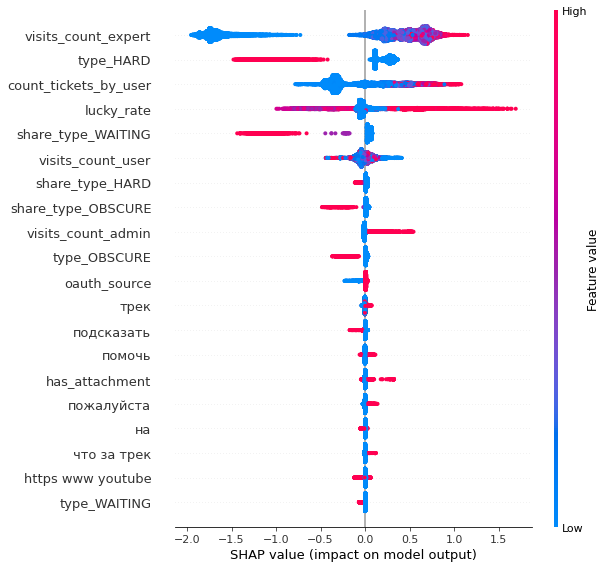

In [62]:
from IPython.display import Image
Image(filename='shap.png') #SHAP запускается не всегда и везде; данный график посчитан в кернеле каггла

Выводы:
* чем больше экспертов просмотрело тикет, тем выше вероятность ответа
* пользователи с меньшим числом тикетов реже получают ответ
* пользователи с высоким Lucky_rate чаще получают ответ

In [ ]:
#Import numpy
import numpy as np

#Import scikitlearn for machine learning functionalities
import sklearn
from sklearn.manifold import TSNE 
from sklearn.datasets import load_digits # For the UCI ML handwritten digits dataset

# Import matplotlib for plotting graphs ans seaborn for attractive graphics.
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
%matplotlib inline

import seaborn as sb

In [45]:
import sklearn
from sklearn.manifold import TSNE

X_train = X_train.fillna(0)
final = TSNE(perplexity=30).fit_transform(X_train)

In [46]:
final

array([[-86.55184 ,  24.055899],
       [-47.478275,  52.691795],
       [ 60.583393,  14.58626 ],
       ...,
       [ 55.701546, -39.818226],
       [ 18.451357, -26.715906],
       [ 15.155038,  69.63222 ]], dtype=float32)

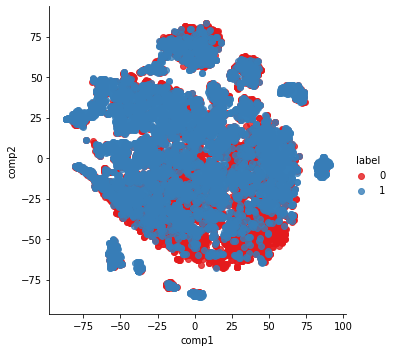

In [49]:
# visualize

import seaborn as sns
import matplotlib.pyplot as plt

df_tsne = pd.DataFrame(final, columns=['comp1', 'comp2'])
df_tsne['label'] = y_train
sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False,palette="Set1")

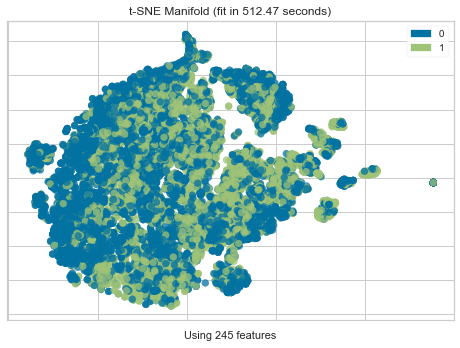

In [52]:
from yellowbrick.features import Manifold

classes = [0, 1]

# Instantiate the visualizer
viz = Manifold(manifold="tsne", classes=classes)

viz.fit_transform(X_train, y_train)  # Fit the data to the visualizer
viz.show()    

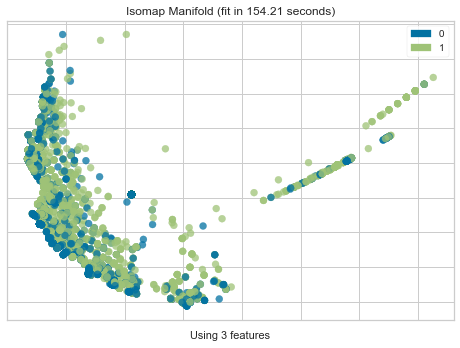

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import f_classif, SelectKBest

model = Pipeline([
    ("selectk", SelectKBest(k=3, score_func=f_classif)),
    ("viz", Manifold(manifold="isomap", n_neighbors=10, classes=classes)),
])

model.fit_transform(X_train, y_train)          # Fit the data to the model
model.named_steps['viz'].show() 

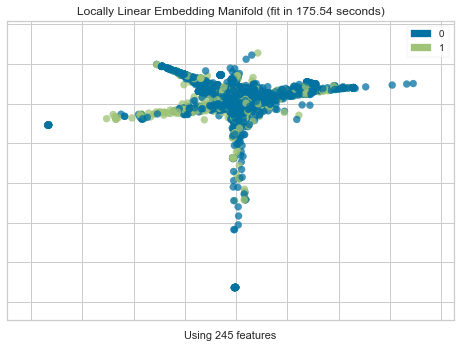

In [54]:
viz = Manifold(manifold="lle", classes=classes)

viz.fit_transform(X_train, y_train)  # Fit the data to the visualizer
viz.show()  

Выводы:
* Нет явно выраженных кластеров; типичная проблема кластеризации для моделей с ROC AUC до 0.9
* Необходимо подключить другие данные - логи пользователей, подробную статистику входов в каждый тикет, а также активность в чате перед закрытием тикета